# 0. 문제정의
날씨의 이미지를 보고 Rain, Cloudy, Shine, Sunset 중 어떤 날씨에 해당하는지 분류할 수 있는 CNN 모델을 만드는 것을 목표로 한다. 해당 데이터는 데이터 분석 대회 플랫폼인 Kaggle에서 제공되는 "Multi-class Weather Dataset for Image Classification(MWD)" 데이터셋을 이용하였다. 

# 1. Import Libraries
CNN 모델을 불러오기 위한 tensorflow.keras의 라이브러리들과 데이터 불러오기 및 저장을 위한 경로 설정에 필요한 os, glob 라이브러리, dataframe을 다루기 위한 numpy 라이브러리를 설치하였다.

In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Activation, BatchNormalization, Dense, Flatten, Add, Input,
    Conv2D, MaxPool2D)
from tensorflow.keras.utils import plot_model
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 2. Set Data Path
Kaggle에서 다운로드 받은 Multi-Weather Dataset을 구글 드라이브에 저장하고, 불러오기 위한 경로를 설정하였다.

In [3]:
base_dir =  r'/content/drive/MyDrive/Colab Notebooks/2022_1 고려대학교/Weather Classification/Multi-class Weather Dataset'
test_dir = r'/content/drive/MyDrive/Colab Notebooks/2022_1 고려대학교/Weather Test Dataset'
folders = os.listdir(base_dir)
print(folders)

['Sunrise', 'Cloudy', 'Rain', 'Shine']


# 3. Download Dataset and Display Sample

## 3-1. Dataset 설명
Multi-class Weather Dataset은 Kaggle에서 제공되는 dataset으로 이미지 데이터를 독립변수, 4종류의 날씨 상태(Cloudy, Rain, Shiny, Sunset)클래스를 종속변수로 한다. <br>
각 날씨 상태 클래스에서 주어진 이미지의 크기는 다르고 이미지의 개수도 다르다. 각 클래스별로 Cloudy는 300개, Rain은 215, Shine은 235개, Sunrise는 357개의 불균형한 데이터를 가지고 있었다.<br>
한편, 주어진 dataset에는 test data가 주어지지 않았다. 따라서 모델 구성 및 학습 이후에 평가를 위해 각 클래스에 맞는 이미지를 구글링하여 외부에서 다운받았다. 다운받은 test data는 모델을 구성한 이후 시각화에 사용되었다.

In [4]:
Cloudy = glob.glob(os.path.join(base_dir, 'Cloudy/*.jpg'))
Rain = glob.glob(os.path.join(base_dir, 'Rain/*.jpg'))
Shine = glob.glob(os.path.join(base_dir, 'Shine/*.jpg'))
Sunrise = glob.glob(os.path.join(base_dir, 'Sunrise/*.jpg'))

In [5]:
# 각 클래스에 따른 모든 이미지를 행렬로 변환하여 저장
Cloudy_img = np.array(list(map(lambda x: (img_to_array(load_img(Cloudy[x]), dtype=np.uint8)), range(len(Cloudy)))))
Rain_img = np.array(list(map(lambda x: (img_to_array(load_img(Rain[x]), dtype=np.uint8)), range(len(Rain)))))
Shine_img = np.array(list(map(lambda x: (img_to_array(load_img(Shine[x]), dtype=np.uint8)), range(len(Shine)))))
Sunrise_img = np.array(list(map(lambda x: (img_to_array(load_img(Sunrise[x]), dtype=np.uint8)), range(len(Sunrise)))))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you me

In [6]:
# 각 class별 이미지의 크기 확인
print(Cloudy_img[0].shape)
print(Rain_img[0].shape)
print(Shine_img[0].shape)
print(Sunrise_img[0].shape)

(149, 338, 3)
(177, 284, 3)
(247, 318, 3)
(160, 240, 3)


## 3-2. Display Sample

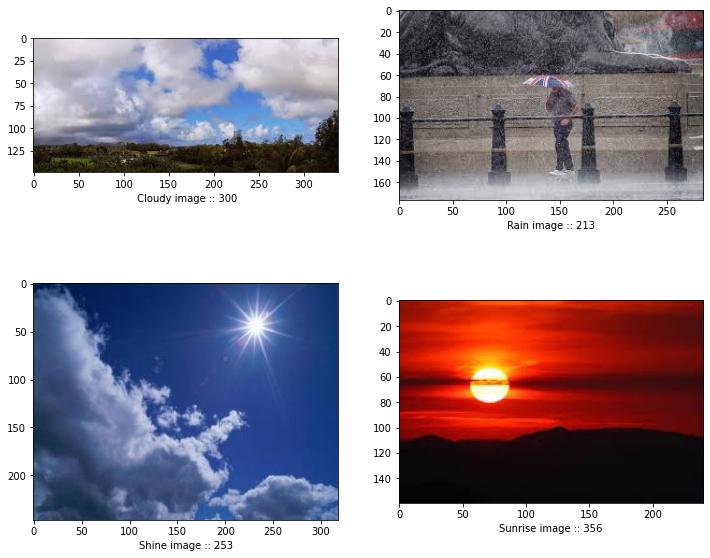

In [7]:
# 대표적인 이미지를 1개씩 시각화하였다

plt.figure(figsize=(12,10))
plt.subplot(2,2,1)
plt.xlabel(f' Cloudy image :: {len(Cloudy)}')
plt.imshow(Cloudy_img[0])

plt.subplot(2,2,2)
plt.xlabel(f'Rain image :: {len(Rain)}')
plt.imshow(Rain_img[0])

plt.subplot(2,2,3)
plt.xlabel(f'Shine image :: {len(Shine)}')
plt.imshow(Shine_img[0])

plt.subplot(2,2,4)
plt.xlabel(f'Sunrise image :: {len(Sunrise)}')
plt.imshow(Sunrise_img[0])

# 4. Data generator with Data Augmentation
이미지 데이터 전처리 및 학습을 쉽게 할 수 있도록 ImageDataGenerator을 구성하였다. <br>
DataGenerator에서는 우선 rescale을 통해 정규화를 진행하였다.<br>

또한, shear_range, zoom_range, horizontal_flip, rotation_range, width_shift_range, height_shift_range 등을 통해 이미지의 기울기, 확대, 수직수평 방향 이동 등의 data augmentation 기법을 활용하였다. Data Augmentation을 통해 모델을 학습하면, 모델은 각 이미지를 사용할때마다 임의로 변형을 가해서 마치 더욱 많은 이미지 데이터를 학습하는 것과 같은 효과를 얻을 수 있다. 이를 통해 1125장이라는 적은 데이터를 통해서도 모델이 유연하게 학습하고, 높은 accuracy를 달성할 수 있을 것이다. <br> 

또한, 주어진 1125장의 이미지 데이터 중 70%(789장)는 train, 30%(336장)는 validation에 사용하였다.

In [8]:
val_split=0.3

train_datagen = ImageDataGenerator(rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=40, # 이미지에 회전
    width_shift_range=0.1,  # 수평 방향 평행이동
    height_shift_range=0.1,  # 수직 방향 평행이동
    validation_split=val_split) # validation split : 30%

train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(250,250),
    batch_size= 32,
    class_mode='categorical',
    subset='training') # Train data

validation_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(250,250),
    batch_size= 32,
    class_mode='categorical',
    subset='validation') # Validation data

datagen_test = ImageDataGenerator(rescale=1./255,)

test_generator = datagen_test.flow_from_directory(
        test_dir,
        target_size=(250,250),
        batch_size=1,
        class_mode='categorical')

Found 789 images belonging to 4 classes.
Found 336 images belonging to 4 classes.
Found 8 images belonging to 4 classes.


In [9]:
len_train_generator= train_generator.samples
len_valid_generator= validation_generator.samples
len_test_generator = test_generator.samples

Data generator에 따라 생성된 4개의 class를 각각 0,1,2,3으로 labeling 하였다.

In [10]:
labels = (train_generator.class_indices)
labels = dict((v , k) for k , v in labels.items())
print(labels)

{0: 'Cloudy', 1: 'Rain', 2: 'Shine', 3: 'Sunrise'}


과제를 수행하는데 메모리 관리를 위해 전역상태를 해제하고 메모리 관리를 위해 clear_session을 추가하였다. <br>
또한, Model의 학습을 반복하며 randomness를 해소하기 위해 random.seed를 고정하였다.

In [11]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

# 5. Create CNN Model
날씨 이미지를 분류하는 문제를 해결하기 위해 CNN 모델을 구성하였다. Model은 구성하는 layer의 종류는 Conv2D, BatchNormalization, Activation, Dropout, Maxpool2D이다.<br><br>

## 5-1. Feature Extractor
Convolution Layer과 Max pooling Layer 모두 (3,3)크기를 가지는 filter를 사용하였다. 또한, data generator에서 설정했던 것과 동일하게 (250,250,3)의 input image를 받을 수 있도록 구성하였다. Model을 구성했을 때, activation map이 소멸하는 것을 방지하기 위해 Max Pooling 과정에서 Padding='same'으로 크기를 고정하였다.<br>

첫번째 Layer에서는 32개의 convolution filter를 사용했고, 두번째 layer에서는 128개의 convolution filter을 사용하였다. Activation function으로는 ReLu를 사용하여 비선형성을 부여하였다. <br>

Filter개수가 128개인 두번째 convolution layer에서는 학습 과정을 안정화하여 학습 속도를 증가시키고 feature들의 분포가 변하는 현상을 줄이기 위해 BatchNormalization layer을 추가하였다. Batch Normalization는 Convolution layer과 ReLu activation function 사이에 배치하였다.<br>
또한, 학습 과정에서의 overfitting을 방지하고자 dropout layer을 추가하였다. Dropout layer에서 일부 parameter들을 적용하지 않음으로써, 여러 model을 학습하여 결합하는 ensemble 효과와 overfitting 방지의 효과를 얻을 수 있다. <br><br>

## 5-2. Classifier
Convolution layer을 모두 거친 이후에는 flatten하여 1차원 array의 Fully Connected Layer 형태로 변환시켰다. 그 후, output의 개수가 16, 8이고 relu를 activation function으로 가지는 Dense Layer을 적용하였다.
마지막 Dense Layer는 데이터의 클래스 개수인 4개의 output을 가지고, categorical classification을 위해 softmax function을 activation function으로 설정하였다.

In [12]:
num_classes = 4

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32,(3,3), input_shape = (250, 250 , 3)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D((3,3),padding='same'),

    tf.keras.layers.Conv2D(128, (3,3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.MaxPool2D((3,3),padding='same'),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(16 , activation = 'relu'),
    tf.keras.layers.Dense(8 , activation = 'relu'),
    
    tf.keras.layers.Dense(num_classes , activation = 'softmax')])

## Model Summary
CNN 모델의 기본적인 layer을 설정한 후에 학습 방식에 대한 parameter들을 조정하였다. Model 최적화에 사용되는 목적함수인 loss는 categorical_crossentropy를 사용하여 클래스가 4개인 분류를 위한 학습을 진행하였다. Optimizer은 SGD를 사용하였고, 초기 learning rate는 0.01로 설정하였다. 평가지표인 metrics는 accuracy로 설정하였다.

In [13]:
model.compile(loss = 'categorical_crossentropy' , optimizer = tf.keras.optimizers.SGD(learning_rate = 0.001) , metrics = 'accuracy')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 248, 248, 32)      896       
                                                                 
 activation (Activation)     (None, 248, 248, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 83, 83, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 81, 81, 128)       36992     
                                                                 
 batch_normalization (BatchN  (None, 81, 81, 128)      512       
 ormalization)                                                   
                                                                 
 activation_1 (Activation)   (None, 81, 81, 128)       0

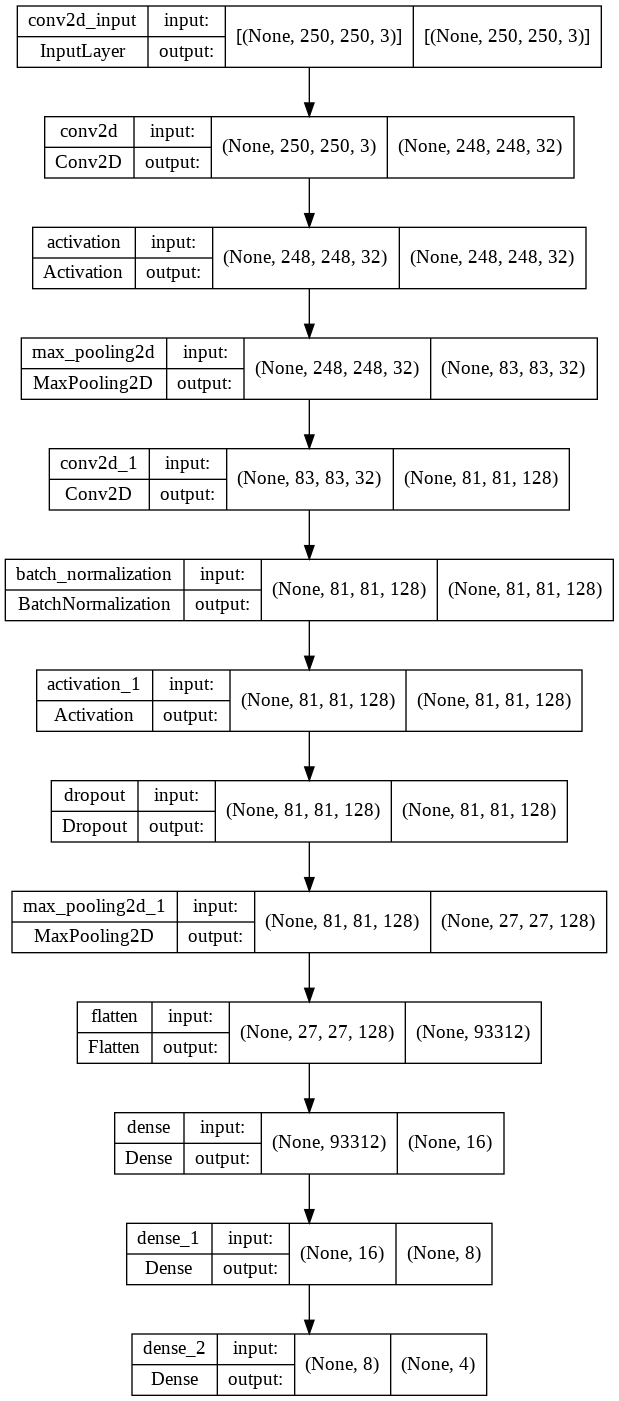

In [14]:
plot_model(model, show_shapes=True, to_file = '/content/drive/MyDrive/Colab Notebooks/model.png')

## Callback Parameters
모델을 학습시키기 전에 학습 조건을 설정하였다.<br><br>
### 1. chekpointer
Model이 학습을 마친 이후 validation accuracy가 가장 뛰어난 모델을 "model_final.hdf5"로 저장하였다. <br><br>

### 2. scheduler
학습을 진행해도 성능이 증가하지 않을 경우 learning rate를 줄여서 더욱 세밀한 학습을 할 수 있도록 변경한다. 이번 과제의 경우, 3회 이상 성능이 향상하지 않을 경우, learning rate에 0.1을 곱해 감소시켰다. Learning rate가 크게 유지될 경우네는 over shooting이 일어나서 loss가 수렴하지 않고 진동할 가능성이 있다. 그러나 learning rate가 작을 경우에는 찾고자 하는 global optima가 아닌 local optima에서 벗어나지 못할 수 있다. 따라서 epoch이 지남에 따라 learning rate를 조정하여 모델이 수렴하면서 빠르게 global optima로 도달할 수 있도록 하였다. <br><br>

### 3. early_stopper
학습이 진행되어도 성능이 향상되지 않을 경우 학습을 멈추도록 하였다. 이번 과제의 경우, 7회 이상 향상되지 않았을 때 학습을 멈추고 최종 모델을 산출하도록 하였다. 이를 통해 model이 학습하면서 overfitting에 빠질 위험을 방지할 수 있다.

In [15]:
# When to save the model
checkpointer = ModelCheckpoint(filepath='/content/drive/MyDrive/model_final.hdf5', monitor='val_accuracy', verbose=1,
                               save_best_only=True)

#Reduce learning rate when loss doesn't improve after n epochs
scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=3, min_lr=1e-8, verbose=1)

# Stop early if model doesn't improve after n epochs
early_stopper = EarlyStopping(monitor='val_loss', patience=7,
                              verbose=7, restore_best_weights=True)

# 6. Train Model
Model 학습을 위해 fit 하는 과정에서 train data와 validation data는 위에서 구성하였던 generator을 사용해서 불러왔다.<br>
학습 epoch은 총 100회로, early stopper을 정의하였기 때문에 충분한 epoch을 설정하였다.<br>
Verbose=1로 설정하여 epoch별로 모델이 학습하는 과정을 출력하도록 하였다.

In [16]:
# training model
history = model.fit(train_generator ,
          validation_data = validation_generator ,
          epochs = 100 ,
          verbose=1,
          callbacks=[checkpointer,scheduler,early_stopper],
          steps_per_epoch = len_train_generator/32, # train_files/batch_size
          validation_steps = len_valid_generator/32,) # valid_files/batch_size 

Epoch 1/100
25/24 [==============================] - ETA: 0s - loss: 1.2466 - accuracy: 0.4753
Epoch 1: val_accuracy improved from -inf to 0.44345, saving model to /content/drive/MyDrive/model_final.hdf5
24/24 [==============================] - 35s 987ms/step - loss: 1.2466 - accuracy: 0.4753 - val_loss: 1.3369 - val_accuracy: 0.4435 - lr: 0.0010
Epoch 2/100
25/24 [==============================] - ETA: 0s - loss: 0.8276 - accuracy: 0.7085
Epoch 2: val_accuracy improved from 0.44345 to 0.48214, saving model to /content/drive/MyDrive/model_final.hdf5
24/24 [==============================] - 23s 946ms/step - loss: 0.8276 - accuracy: 0.7085 - val_loss: 1.2946 - val_accuracy: 0.4821 - lr: 0.0010
Epoch 3/100
25/24 [==============================] - ETA: 0s - loss: 0.6022 - accuracy: 0.7947
Epoch 3: val_accuracy improved from 0.48214 to 0.54167, saving model to /content/drive/MyDrive/model_final.hdf5
24/24 [==============================] - 23s 925ms/step - loss: 0.6022 - accuracy: 0.7947 - 

# 7. Plot Model History
Model을 학습시킨 결과, 42번째 epoch에서 early_stopper가 작동하여 학습이 멈추었고, 저장된 최고 성능으로는 0.88690의 validation accuracy와 0.3885의 validation loss를 보였다. Model의 학습 과정을 시각화시킨 결과, overfitting이나 gradient vanishing 등의 문제 없이 학습이 진행되었다. 특히, 초중반에는 accuracy가 진동하는 경향이 있었지만 learning rate를 조정함에 따라 수렴하는 것을 확인할 수 있다.

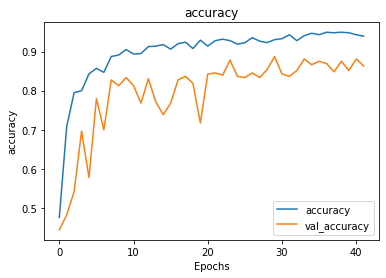

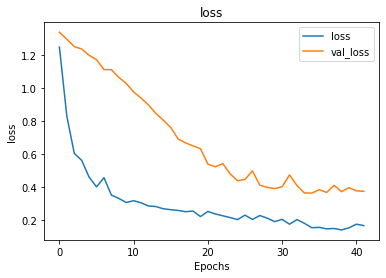

In [17]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.title(string)
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

# 8. Test Model
모델을 evaluation하기 이전에 시각적으로 예측을 잘 했는지 확인하기 위해서 test data에서 임의의 사진을 모델에 대입하여 예측하였다. <br>
이미지 경로를 array로 변환하여 모델에 입력하고, 시각화하는 prediction 함수를 만들었고, Cloudy image를 대입해본 결과 cloudy에 속한다는 것을 0.95의 정확도를 가지며 올바르게 예측했음을 확인했다.

In [18]:
# 최종 모델 불러오기
from tensorflow.python.keras.models import load_model
model_final = tf.keras.models.load_model('/content/drive/MyDrive/model_final.hdf5')

In [19]:
def prediction(test_path):
    img = image.load_img(test_path , target_size = (250 , 250))
    img = image.img_to_array(img, dtype=np.uint8)
    img = np.array(img)/255.0

    plt.title('Image')
    plt.axis('off')
    plt.imshow(img.squeeze())

    predict = model_final.predict(img[np.newaxis , ...])
    predicted_class = labels[np.argmax(predict[0] , axis = -1)]

    print('Prediction Value: ' , np.max(predict[0] , axis = -1))
    print("Classified:",predicted_class)

Prediction Value:  0.38967675
Classified: Shine


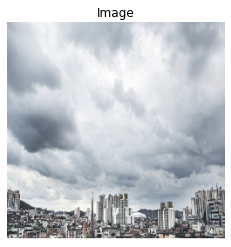

In [42]:
prediction('/content/drive/MyDrive/Colab Notebooks/2022_1 고려대학교/Weather Test Dataset/Cloudy/Cloudy_test_1.jpg')

Prediction Value:  0.63951474
Classified: Cloudy


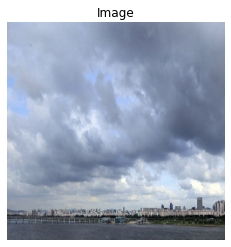

In [43]:
prediction('/content/drive/MyDrive/Colab Notebooks/2022_1 고려대학교/Weather Test Dataset/Cloudy/Cloudy_test_2.jpg')

Prediction Value:  0.9619972
Classified: Rain


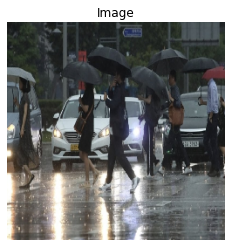

In [40]:
prediction('/content/drive/MyDrive/Colab Notebooks/2022_1 고려대학교/Weather Test Dataset/Rainy/Rainy_test_1.jpg')

Prediction Value:  0.91469395
Classified: Rain


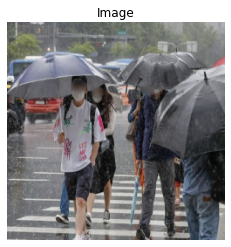

In [41]:
prediction('/content/drive/MyDrive/Colab Notebooks/2022_1 고려대학교/Weather Test Dataset/Rainy/Rainy_test_2.jpg')

Prediction Value:  0.67738575
Classified: Shine


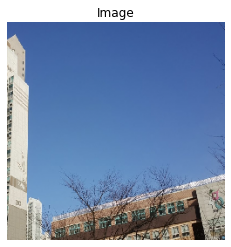

In [44]:
prediction('/content/drive/MyDrive/Colab Notebooks/2022_1 고려대학교/Weather Test Dataset/Shine/Shine_test_1.jpg')

Prediction Value:  0.8773187
Classified: Shine


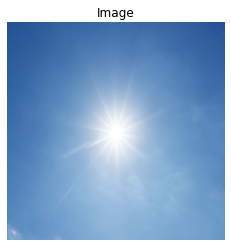

In [38]:
prediction('/content/drive/MyDrive/Colab Notebooks/2022_1 고려대학교/Weather Test Dataset/Shine/Shine_test_2.jpg')

Prediction Value:  0.91893697
Classified: Sunrise


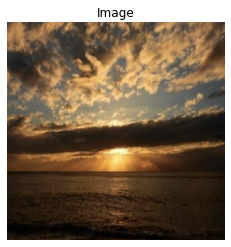

In [34]:
prediction('/content/drive/MyDrive/Colab Notebooks/2022_1 고려대학교/Weather Test Dataset/Sunrise/Sunrise_test_1.jpg')

Prediction Value:  0.5787895
Classified: Sunrise


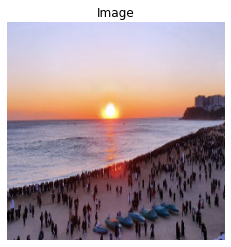

In [45]:
prediction('/content/drive/MyDrive/Colab Notebooks/2022_1 고려대학교/Weather Test Dataset/Sunrise/Sunrise_test_2.jpg')

In [49]:
score = model_final.evaluate(test_generator, steps= len_test_generator, verbose=1)
print('\n', 'Test accuracy:', score[1])

8/8 [==============================] - 0s 17ms/step - loss: 0.3634 - accuracy: 0.8750

 Test accuracy: 0.875


# 9. Conclusion
## 9-1. 결과
실험 결과 Validation Dataset에 대해 88.690%의 높은 accuracy를 보였고, 임의로 선정한 Test image에 대해 0.875의 정확도를 가지고 올바른 class로 예측하였다. 실제로 각 image들에 대해 prediction value를 측정해본 결과, 대부분의 image에서 높은 정확도를 보임을 알 수 있었다. 학습에 이용한 총 이미지가 적었음에도 불구하고 날씨를 4개의 클래스로 분류하는 모델을 구성할 수 있었다.<br>

## 9-2. 아쉬웠던 점
한편, 실험 과정에서 아쉬웠던 점도 많았다. 처음에 Model을 구성할 때에는 256 convolution filter까지 사용하며 깊은 모델을 만들었었지만, 성능이 좋지 않았고 오히려 학습이 진행될 수록 accuracy가 감소하는 모습을 보였다.<br>

Batch Normalization과 Optimizer, learning rate를 바꾸는 등 여러가지 경우를 실험해보았지만, overfitting 문제와 gradient vanishing 문제가 계속 발생하였고, validation accuracy가 0.30 정도에서 진동하는 모습을 보였다. <br>

데이터의 양에 비해 model의 parameter가 너무 많았고, 학습 시간이 부족했기 때문에 정상적인 학습을 진행하지 못했던 것 같다. 또한, 기존에는 Adam optimizer을 사용했었지만 성능이 좋지 않았고, 오히려 SGD optimizerdmf 사용했을 때 개선되는 모습을 보였다. 오히려 2개의 Convolution layer을 가지는 CNN 모델이 가장 뛰어난 성능을 보였다. 이번 과제를 통해 단순히 모델을 깊게 쌓는 것이 뛰어난 성능을 보장하는 것이 아니라는 것을 깨달았고, 딥러닝 모델을 학습시키기 위해서는 충분한 데이터의 양이 가장 필수적이라는 것 또한 알 수 있었다.<br>

## 9-3. 개선점
이번 과제에서 해결하고하는 문제를 더욱 효율적이고 높은 성능으로 해결하기 위해 전이학습을 시도해보고 싶다. 특히, Imagenet으로 pretrained된 InceptionV3 혹은 ResNet50등을 keras model에서 직접 불러와서 사용해볼 수 있을 것이다. 전이학습을 통해 parameter들을 freeze시켜 fine tuning 학습을 한다면 직접 layer을 쌓아서 구현하는 것에 비해 학습 속도도 훨씬 빠르고 효율적인 학습을 할 수 있었을 것이다. 그러나 모델을 직접 구성하는 경험을 통해 CNN을 구성하는 layer들과 각종 parameter들에 대한 이해도가 높아졌고, 추후에 deep learning 프로젝트를 진행하는데에 큰 도움이 될 것이라고 확신한다.
